# Retinopathy Detection using Machine Learning

In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['aptos2019-blindness-detection', 'weights', 'models-pretrained-weights']


In [15]:
# importing the necesary packages
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras.models import Model
from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input

In [16]:
# reading the labels which is in .CSV format
train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

In [17]:
# printing the number of train and test samples
print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])
display(train.head())

Number of train samples:  3662
Number of test samples:  1928


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [28]:
# Model parameters
BATCH_SIZE = 16
EPOCHS = 30
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 320
WIDTH = 320
CANAL = 3
N_CLASSES = train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 4
DECAY_DROP = 0.6

In [20]:
# Preprocecss data
train["id_code"] = train["id_code"].apply(lambda x: x + ".png")
test["id_code"] = test["id_code"].apply(lambda x: x + ".png")
train['diagnosis'] = train['diagnosis'].astype('str')
train.head()

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


In [29]:
# Generating new images for the existing images
train_datagen=ImageDataGenerator(rescale=1./255,
                                rotation_range=30,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                validation_split=0.2,
                                zoom_range=0.25)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="../input/aptos2019-blindness-detection/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=(HEIGHT, WIDTH),
    subset='training')

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="../input/aptos2019-blindness-detection/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",    
    target_size=(HEIGHT, WIDTH),
    subset='validation')

def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = applications.DenseNet201(weights=None,include_top=False,input_tensor=input_tensor)
    base_model.load_weights('../input/models-pretrained-weights/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5')
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.6)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.6)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    return model

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test,
        directory = "../input/aptos2019-blindness-detection/test_images/",
        x_col="id_code",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.


In [30]:
# Function for calculating Precision, Recall, F1 score
from keras import backend as K
from keras.optimizers import Adam


def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [31]:
# building a model
model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True

metric_list = ['accuracy',f1_m,precision_m, recall_m]
optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 320, 320, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_5 (ZeroPadding2D (None, 326, 326, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 160, 160, 64) 9408        zero_padding2d_5[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 160, 160, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

__________________________________________________________________________________________________
conv5_block24_0_relu (Activatio (None, 10, 10, 1632) 0           conv5_block24_0_bn[0][0]         
__________________________________________________________________________________________________
conv5_block24_1_conv (Conv2D)   (None, 10, 10, 128)  208896      conv5_block24_0_relu[0][0]       
__________________________________________________________________________________________________
conv5_block24_1_bn (BatchNormal (None, 10, 10, 128)  512         conv5_block24_1_conv[0][0]       
__________________________________________________________________________________________________
conv5_block24_1_relu (Activatio (None, 10, 10, 128)  0           conv5_block24_1_bn[0][0]         
__________________________________________________________________________________________________
conv5_block24_2_conv (Conv2D)   (None, 10, 10, 32)   36864       conv5_block24_1_relu[0][0]       
__________

In [32]:
# Assigning weights to each class, as the data is imbalanced
class_weights={0:1,1:1.15,2:1,3:1.25,4:1.01}

In [33]:
# fitting the model and warming up the model with two epochs
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history_warmup = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=WARMUP_EPOCHS,
                              verbose=1,class_weight=class_weights).history


Epoch 1/2
183/183 [==============================] - 501s 3s/step - loss: 1.4968 - acc: 0.5622 - f1_m: 0.5551 - precision_m: 0.6108 - recall_m: 0.5126 - val_loss: 1.0578 - val_acc: 0.6625 - val_f1_m: 0.6147 - val_precision_m: 0.7164 - val_recall_m: 0.5431
Epoch 2/2
183/183 [==============================] - 455s 2s/step - loss: 1.0664 - acc: 0.6335 - f1_m: 0.6104 - precision_m: 0.7153 - recall_m: 0.5379 - val_loss: 1.0033 - val_acc: 0.6425 - val_f1_m: 0.5490 - val_precision_m: 0.8715 - val_recall_m: 0.4078


In [34]:
# using methods like Early stopping and modelcheckpoint to avoid overfitting of data
from keras.callbacks import EarlyStopping, ModelCheckpoint

for layer in model.layers:
    layer.trainable = True

rlrop = ReduceLROnPlateau(monitor='val_f1_m', mode='max', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)
es = EarlyStopping(monitor='val_f1_m', mode='max', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
mc=ModelCheckpoint('model_weights_try8.h5',monitor="val_f1_m",save_best_only=True,mode='max',verbose=1)

callback_list = [es, rlrop,mc]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=metric_list)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 320, 320, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_5 (ZeroPadding2D (None, 326, 326, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 160, 160, 64) 9408        zero_padding2d_5[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 160, 160, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

conv5_block9_concat (Concatenat (None, 10, 10, 1184) 0           conv5_block8_concat[0][0]        
                                                                 conv5_block9_2_conv[0][0]        
__________________________________________________________________________________________________
conv5_block10_0_bn (BatchNormal (None, 10, 10, 1184) 4736        conv5_block9_concat[0][0]        
__________________________________________________________________________________________________
conv5_block10_0_relu (Activatio (None, 10, 10, 1184) 0           conv5_block10_0_bn[0][0]         
__________________________________________________________________________________________________
conv5_block10_1_conv (Conv2D)   (None, 10, 10, 128)  151552      conv5_block10_0_relu[0][0]       
__________________________________________________________________________________________________
conv5_block10_1_bn (BatchNormal (None, 10, 10, 128)  512         conv5_block10_1_conv[0][0]       
__________

In [35]:
# Training the model with 30 epochs
history_finetunning = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=EPOCHS,
                              callbacks=callback_list,
                              verbose=1,class_weight=class_weights).history

Epoch 1/30
183/183 [==============================] - 562s 3s/step - loss: 0.2580 - acc: 0.8966 - f1_m: 0.7031 - precision_m: 0.8136 - recall_m: 0.6250 - val_loss: 0.2420 - val_acc: 0.9000 - val_f1_m: 0.7246 - val_precision_m: 0.8009 - val_recall_m: 0.6648

Epoch 00001: val_f1_m improved from -inf to 0.72459, saving model to model_weights_try8.h5
Epoch 2/30
183/183 [==============================] - 459s 3s/step - loss: 0.2209 - acc: 0.9106 - f1_m: 0.7516 - precision_m: 0.8379 - recall_m: 0.6861 - val_loss: 0.2098 - val_acc: 0.9128 - val_f1_m: 0.7573 - val_precision_m: 0.8495 - val_recall_m: 0.6872

Epoch 00002: val_f1_m improved from 0.72459 to 0.75732, saving model to model_weights_try8.h5
Epoch 3/30
183/183 [==============================] - 474s 3s/step - loss: 0.1993 - acc: 0.9173 - f1_m: 0.7764 - precision_m: 0.8401 - recall_m: 0.7247 - val_loss: 0.2028 - val_acc: 0.9000 - val_f1_m: 0.7188 - val_precision_m: 0.8205 - val_recall_m: 0.6439

Epoch 00003: val_f1_m did not improve fro

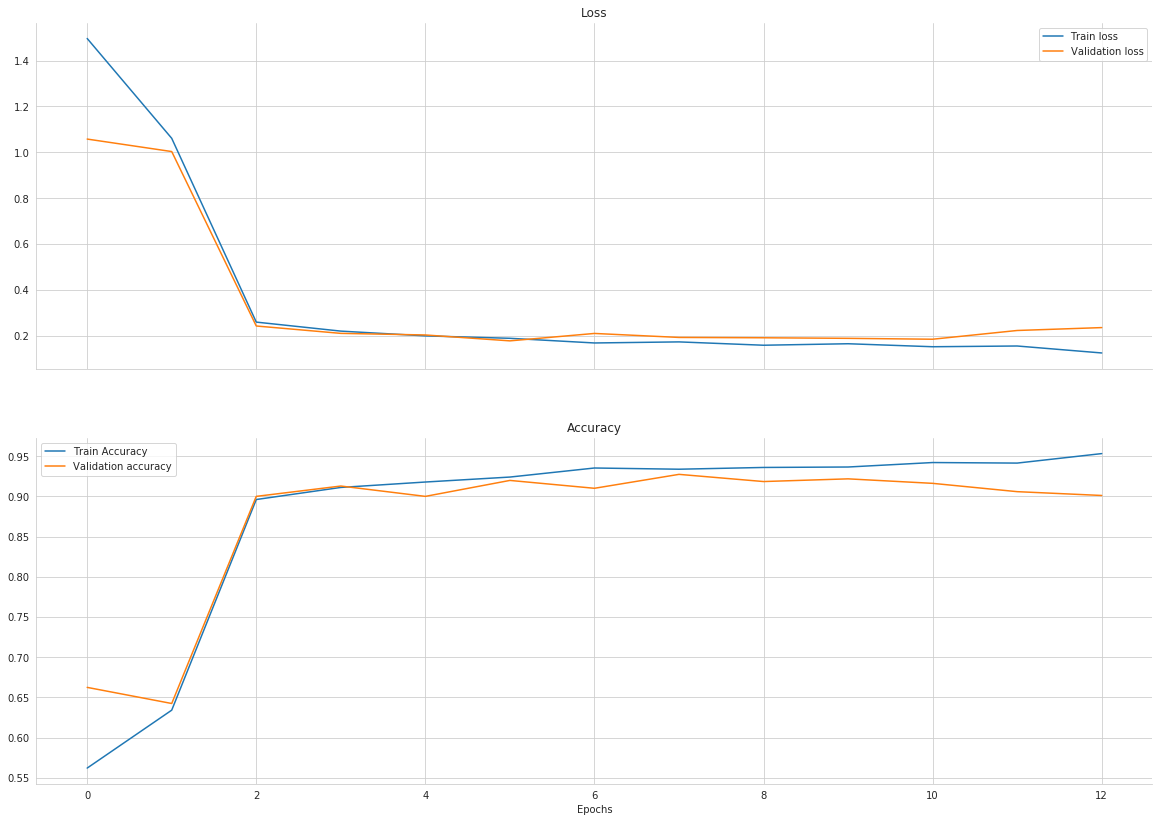

In [36]:
# Plotting the loss and accuracy for train and validation data
history = {'loss': history_warmup['loss'] + history_finetunning['loss'], 
           'val_loss': history_warmup['val_loss'] + history_finetunning['val_loss'], 
           'acc': history_warmup['acc'] + history_finetunning['acc'], 
           'val_acc': history_warmup['val_acc'] + history_finetunning['val_acc']}

sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['acc'], label='Train Accuracy')
ax2.plot(history['val_acc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [37]:
# preparing the test data
complete_datagen = ImageDataGenerator(rescale=1./255)
complete_generator = complete_datagen.flow_from_dataframe(  
        dataframe=train,
        directory = "../input/aptos2019-blindness-detection/train_images/",
        x_col="id_code",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

STEP_SIZE_COMPLETE = complete_generator.n//complete_generator.batch_size
train_preds = model.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE)
train_preds = [np.argmax(pred) for pred in train_preds]

Found 3662 validated image filenames.


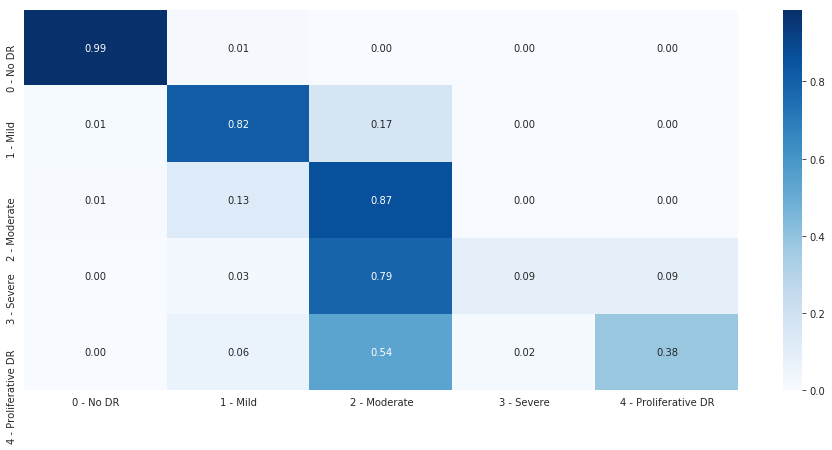

In [38]:
# confusion matrix for the train data to see how well the model has learnt
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
cnf_matrix = confusion_matrix(train['diagnosis'].astype('int'), train_preds)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

In [39]:
# kappa score for train data
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, train['diagnosis'].astype('int'), weights='quadratic'))

Train Cohen Kappa score: 0.881


In [40]:
# prediction for test data using the model built
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST)
predictions = [np.argmax(pred) for pred in preds]

In [41]:
# predicted class for the test image
filenames = test_generator.filenames
results = pd.DataFrame({'id_code':filenames, 'diagnosis':predictions})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])
results.to_csv('submission.csv',index=False)
results.head(10)

,id_code,diagnosis
0,0005cfc8afb6,1
1,003f0afdcd15,2
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,2
5,009c019a7309,2
6,010d915e229a,2
7,0111b949947e,1
8,01499815e469,3
9,0167076e7089,0


In [42]:
# count of the predicted result of each class
results['diagnosis'].value_counts()

2    1227
1     385
0     230
3      55
4      31
Name: diagnosis, dtype: int64

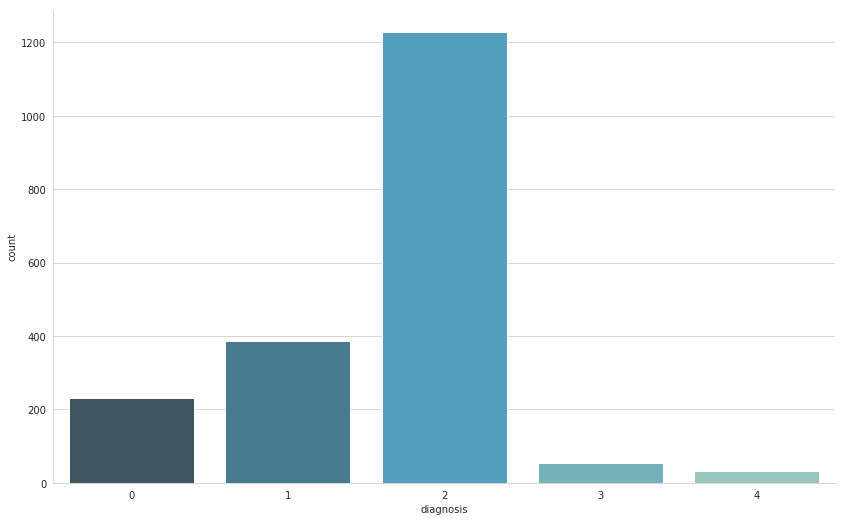

In [43]:
# bar plot of predicted class for test image
f, ax = plt.subplots(figsize=(14, 8.7))
ax = sns.countplot(x="diagnosis", data=results, palette="GnBu_d")
sns.despine()
plt.show()

## Steps:

1) The data is higly imbalance 

2) We resize the image size to 320*320

3) We use the training data to generate new images with a little alteration in the images - Data Augmentation

4) As the data is less and with low computational power, we will use pretrained weights - Densenet-201 to build model and add a layer to classify the data.

5) Assigning the weights to each class as the data is imbalance.

6) We use methods like Early stopping with validation F1-score and modelcheckpoint to avoid overfitting of data

7) We train the last 5 layers with two epochs as warmup.

8) Training the model with 30 epochs but the model stops at 11 epochs using Early Stopping.

9) Plotting the loss and accuracy for both train and validation data. 

10) Confusion Matrix to see how the model learnt on train data. 

11) Prediction for test data using the model that is built.

### The Kappa Score on test data is 0.714 